In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import spacy

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import DistilBertModel, DistilBertTokenizer
from huggingface_hub import notebook_login, PyTorchModelHubMixin

c:\Users\grumpy\anaconda3\envs\nlp\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\grumpy\anaconda3\envs\nlp\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\grumpy\anaconda3\envs\nlp\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# 🧑‍💻 CUDA Specification


In [2]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

# 📚 Import Data


In [3]:
if "google.colab" in str(get_ipython()):
    colab_data_path = (
        "/content/drive/MyDrive/Colab Notebooks/NLP/Music Genre Classification"
    )

    df_train = pd.read_csv(colab_data_path + "/data/train_clean.csv.zip")
    df_val = pd.read_csv(colab_data_path + "/data/val_clean.csv.zip")
    df_test = pd.read_csv(colab_data_path + "/data/test_clean.csv.zip")
else:
    df_train = pd.read_csv("data/train_clean.csv.zip")
    df_val = pd.read_csv("data/val_clean.csv.zip")
    df_test = pd.read_csv("data/test_clean.csv.zip")

In [4]:
print(f"🏃‍♂️ Train shape: {df_train.shape}")
print(f"🏋️ Validation shape: {df_val.shape}")
print(f"🧐 Test shape: {df_test.shape}")

🏃‍♂️ Train shape: (5000, 15)
🏋️ Validation shape: (1020, 15)
🧐 Test shape: (1134, 15)


## 📖 Define the data


In [5]:
MODEL_NAME = "distilbert-base-uncased"
SPACY_MODEL = "en_core_web_sm"

In [6]:
GENRE_MAPPING = {"edm": 0, "r&b": 1, "rap": 2, "rock": 3, "pop": 4}

In [7]:
AUDIO_FEATURES = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
]

In [8]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 2e-05

# 🧩 Tokenizer from DistilBERT


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# 🧠 Preprocessing


In [10]:
class LyricsAudioDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.lyrics = dataframe.lyrics
        self.audio = dataframe[AUDIO_FEATURES]
        self.targets = self.data.playlist_genre.map(GENRE_MAPPING)
        self.max_len = max_len

        # Load Spacy model for text preprocessing
        self.nlp = spacy.load(SPACY_MODEL, disable=["parser", "ner"])

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyrics = self._preprocess(str(self.lyrics[index]))

        inputs = self.tokenizer.encode_plus(
            lyrics,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "audio": torch.tensor(self.audio.iloc[index].values, dtype=torch.float),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

    def _preprocess(self, text):
        doc = self.nlp(text)
        processed_text = " ".join(
            [
                token.lemma_.lower()
                for token in doc
                if not token.is_stop and token.lemma_.isalpha()
            ]
        )
        return processed_text

In [11]:
training_set = LyricsAudioDataset(df_train, tokenizer, MAX_LEN)
validation_set = LyricsAudioDataset(df_val, tokenizer, MAX_LEN)
testing_set = LyricsAudioDataset(df_test, tokenizer, MAX_LEN)

In [12]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}
val_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": False, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

# 📐 Modeling


In [13]:
class DistilBertClass(nn.Module, PyTorchModelHubMixin):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME)
        self.pre_classifier = nn.Linear(768 + len(AUDIO_FEATURES), 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, len(GENRE_MAPPING))

        self.model_config = {
            "model_type": "distilbert",
            "transformers_version": "4.9",
            "pytorch_version": "1.9",
            "base_model": "distilbert-base-uncased",
            "use_auth_token": "False",
            "revision": "main",
            "task": "text-classification",
            "dataset": "spotify_songs",
            "setting": {
                "train_batch_size": TRAIN_BATCH_SIZE,
                "val_batch_size": VALID_BATCH_SIZE,
                "max_len": MAX_LEN,
                "epochs": EPOCHS,
                "learning_rate": LEARNING_RATE,
                "optimizer": "AdamW",
            },
        }

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, audio=None
    ):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = torch.cat((pooler, audio), 1)
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [14]:
model = DistilBertClass()
model.to(device)

DistilBertClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [16]:
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx == targets).sum().item()
    return n_correct

## 🧪 Training


In [17]:
def train(epoch, model, train_loader, loss_function, optimizer, device):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    model.train()

    print(f"🏃‍♂️ Training Epoch: {epoch + 1}")

    for _, batch in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        audio_features = batch["audio"].to(device, dtype=torch.float)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()

        # Calculate and accumulate correct predictions
        _, predictions = torch.max(outputs.data, dim=1)
        correct_predictions += (predictions == targets).sum().item()

        total_samples += targets.size(0)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Training Epoch {epoch + 1} Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 📈 Evaluation


In [18]:
def evaluate(model, eval_loader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    print(f"🧐 Evaluating Model...")

    with torch.no_grad():
        for _, batch in tqdm(enumerate(eval_loader, 0), total=len(eval_loader)):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Calculate and accumulate correct predictions
            _, predictions = torch.max(outputs.data, dim=1)
            correct_predictions += (predictions == targets).sum().item()

            total_samples += targets.size(0)

    epoch_loss = total_loss / len(eval_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Evaluation Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 🥧 Complie


In [19]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(
        epoch, model, training_loader, loss_function, optimizer, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    validation_loss, validation_accuracy = evaluate(
        model, validation_loader, loss_function, device
    )
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

print("🎯 Training complete!")

🏃‍♂️ Training Epoch: 1


100%|██████████| 625/625 [02:30<00:00,  4.16it/s]


🏁 Training Epoch 1 Complete | Loss: 1.4983 | Accuracy: 37.78%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:30<00:00,  8.40it/s]


🏁 Evaluation Complete | Loss: 1.2388 | Accuracy: 48.14%

🏃‍♂️ Training Epoch: 2


100%|██████████| 625/625 [02:30<00:00,  4.14it/s]


🏁 Training Epoch 2 Complete | Loss: 1.2043 | Accuracy: 52.02%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:23<00:00, 11.09it/s]


🏁 Evaluation Complete | Loss: 1.1684 | Accuracy: 50.10%

🏃‍♂️ Training Epoch: 3


100%|██████████| 625/625 [02:32<00:00,  4.10it/s]


🏁 Training Epoch 3 Complete | Loss: 0.9805 | Accuracy: 62.38%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:23<00:00, 11.07it/s]


🏁 Evaluation Complete | Loss: 1.1885 | Accuracy: 52.55%

🏃‍♂️ Training Epoch: 4


100%|██████████| 625/625 [02:30<00:00,  4.16it/s]


🏁 Training Epoch 4 Complete | Loss: 0.7095 | Accuracy: 74.08%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:23<00:00, 10.96it/s]


🏁 Evaluation Complete | Loss: 1.2990 | Accuracy: 52.25%

🏃‍♂️ Training Epoch: 5


100%|██████████| 625/625 [02:32<00:00,  4.09it/s]


🏁 Training Epoch 5 Complete | Loss: 0.4535 | Accuracy: 84.28%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:22<00:00, 11.13it/s]

🏁 Evaluation Complete | Loss: 1.6531 | Accuracy: 53.63%

🎯 Training complete!


# 📊 Visualization


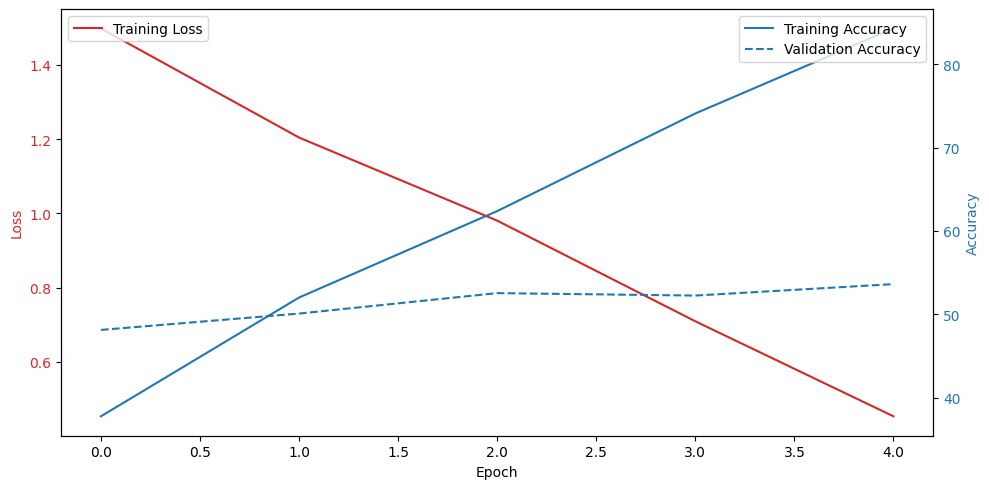

In [24]:
def plot_metrics(train_losses, train_accuracies, validation_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(train_losses, label="Training Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")

    ax2.plot(train_accuracies, label="Training Accuracy", color="tab:blue")
    ax2.plot(
        validation_accuracies,
        label="Validation Accuracy",
        linestyle="--",
        color="tab:blue",
    )
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()


plot_metrics(train_losses, train_accuracies, validation_accuracies)

# ☁️ Upload to Hugging Face


In [28]:
if validation_accuracies[-1] > 50.0:
    repository_name = "PunGrumpy/music-genre-classification"
    model.save_pretrained(repository_name)
    tokenizer.save_pretrained(repository_name)
    print(f"Model saved to {repository_name}")

    model.push_to_hub(repository_name, use_auth_token=True, config=model.model_config)
    tokenizer.push_to_hub(repository_name, use_auth_token=True)
    print(f"Model pushed to {repository_name}")

Model saved to PunGrumpy/music-genre-classification
Model pushed to PunGrumpy/music-genre-classification


# 🛟 Save Model and Tokenizer


In [ ]:
torch.save(model.state_dict(), "model/distilbert_music_genre_classification.bin")
torch.save(tokenizer, "model/distilbert_music_genre_classification_tokenizer.bin")

# 😵 Report


In [ ]:
from sklearn.metrics import classification_report


def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for _, batch in tqdm(
            enumerate(data_loader, 0), total=len(data_loader), desc="Predicting"
        ):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            _, preds = torch.max(outputs, dim=1)

            predictions.append(preds)
            real_values.append(targets)

    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()

    return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(model, testing_loader)
print(classification_report(y_test, y_pred, target_names=GENRE_MAPPING.keys()))

100%|██████████| 284/284 [00:17<00:00, 16.69it/s]

              precision    recall  f1-score   support

         edm       0.37      0.66      0.48       156
         r&b       0.57      0.49      0.53       237
         rap       0.75      0.78      0.76       137
        rock       0.68      0.45      0.54       304
         pop       0.43      0.44      0.43       300

    accuracy                           0.52      1134
   macro avg       0.56      0.56      0.55      1134
weighted avg       0.56      0.52      0.53      1134

